Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# Accelerated MRI reconstruction with U-Net
Accelerated MRI reconstruction is a compressed sensing task where the goal is to recover a ground-truth image from an under-sampled measurement. The under-sampled measurement is based in the frequency domain and is often called the $k$-space.

U-Net based accelerated MRI reconstruction works as follows (note that this is one possible approach). First the under-sampled measurement is transformed to the image domain to form a "zero-filled" image. Then, the zero-filled image is fed into U-Net for reconstruction. U-Net is trained supervised to learn a mapping from the zero-filled input to the ground-truth image.

U-Net was first used for this problem by Jin e. al. [https://arxiv.org/abs/1611.03679](https://arxiv.org/abs/1611.03679)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [ ]:
import numpy as np
import torch
import warnings
import random
import json
from fastmri_ssim import skimage_ssim
import matplotlib.pyplot as plt

from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureTyped,
    ThresholdIntensityd,
)

from monai.apps.reconstruction.transforms.dictionary import (
    ExtractDataKeyFromMetaKeyd,
    RandomKspaceMaskd,
    EquispacedKspaceMaskd,
    ReferenceBasedSpatialCropd,
    ReferenceBasedNormalizeIntensityd,
)

from monai.apps.reconstruction.fastmri_reader import FastMRIReader
from monai.networks.nets import BasicUNet

from pathlib import Path
from monai.config import print_config
from monai.data import CacheDataset, DataLoader

from collections import defaultdict

warnings.filterwarnings("ignore")

print_config()

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.1.0+2.g97918e46
Numpy version: 1.22.2
Pytorch version: 1.13.0a0+d0d6b1f
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 97918e46e0d2700c050e678d72e3edb35afbd737
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.10.1
gdown version: 4.6.0
TorchVision version: 0.14.0a0
tqdm version: 4.64.1
lmdb version: 1.3.0
psutil version: 5.9.2
pandas version: 1.4.4
einops version: 0.6.0
transformers version: 4.21.3
mlflow version: 2.0.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup validation hyper-parameters

In [ ]:
class Args:
    def __init__(self):
        self.batch_size = 1  # can be set to >1 when input sizes are not different
        self.num_workers = 0
        self.cache_rate = 0.0  # what fraction of the data to be cached for faster loading
        self.data_path_val = "/data/fastmri/multicoil_val/"  # path to the validation set
        self.sample_rate = 0.9  # select 0.9 of the validation set for inference
        self.accelerations = [4]  # acceleration factors used for valdiation.
        self.center_fractions = [0.08]  # center_fractions used for valdiation.

        self.mask_type = "equispaced"  # mask type used for validation, current options: ['equispaced', 'random']

        self.drop_prob = 0.0  # inference-time dropout rate
        self.features = [32, 64, 128, 256, 512, 32]  # default U-Net feature sizes based on our model checkpoint


args = Args()

if multiple values are given for accelerations or center_fractions, one will be uniformly chosen for each sample.

## Create validation data loader

In [ ]:
with open("./data/fastmri_data_split.json", "r") as fn:
    data = json.load(fn)
test_files = data["test_files"]
fastmri_val_set = list(Path(args.data_path_val).iterdir())
test_files = [f for f in fastmri_val_set if str(f).split("/")[-1] in test_files]

In [ ]:
random.shuffle(test_files)
test_files = test_files[
    : int(args.sample_rate * len(test_files))
]  # select a subset of the data according to sample_rate
test_files = [{"kspace": f} for f in test_files]
print(f"#test files: {len(test_files)}")

# define mask transform type (e.g., whether it is equispaced or random)
if args.mask_type == "random":
    MaskTransform = RandomKspaceMaskd(
        keys=["kspace"],
        center_fractions=args.center_fractions,
        accelerations=args.accelerations,
        spatial_dims=2,
        is_complex=True,
    )
elif args.mask_type == "equispaced":
    MaskTransform = EquispacedKspaceMaskd(
        keys=["kspace"],
        center_fractions=args.center_fractions,
        accelerations=args.accelerations,
        spatial_dims=2,
        is_complex=True,
    )

test_transforms = Compose(
    [
        LoadImaged(keys=["kspace"], reader=FastMRIReader, image_only=False, dtype=np.complex64),
        # user can also add other random transforms
        ExtractDataKeyFromMetaKeyd(keys=["reconstruction_rss", "mask"], meta_key="kspace_meta_dict"),
        MaskTransform,
        ReferenceBasedSpatialCropd(keys=["kspace_masked_ifft"], ref_key="reconstruction_rss"),
        ReferenceBasedNormalizeIntensityd(
            keys=["kspace_masked_ifft", "reconstruction_rss"], ref_key="kspace_masked_ifft", channel_wise=True
        ),
        ThresholdIntensityd(keys=["kspace_masked_ifft", "reconstruction_rss"], threshold=6.0, above=False, cval=6.0),
        ThresholdIntensityd(keys=["kspace_masked_ifft", "reconstruction_rss"], threshold=-6.0, above=True, cval=-6.0),
        EnsureTyped(keys=["kspace", "kspace_masked_ifft", "reconstruction_rss"]),
    ]
)

test_ds = CacheDataset(
    data=test_files, transform=test_transforms, cache_rate=args.cache_rate, num_workers=args.num_workers
)
test_loader = DataLoader(test_ds, batch_size=args.batch_size, shuffle=False, num_workers=args.num_workers)

## Load model checkpoint

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BasicUNet(spatial_dims=2, in_channels=1, out_channels=1, features=[32, 64, 128, 256, 512, 32]).to(device)

checkpoint = torch.load("./demo_checkpoint/unet_mri_reconstruction.pt", map_location=device)
model.load_state_dict(checkpoint)

BasicUNet features: (32, 64, 128, 256, 512, 32).


<All keys matched successfully>

## Perform inference

In [ ]:
outputs = defaultdict(list)
targets = defaultdict(list)
with torch.no_grad():
    val_ssim = []
    step = 1
    for test_data in test_loader:
        input, target, mean, std, fname = (
            test_data["kspace_masked_ifft"],
            test_data["reconstruction_rss"],
            test_data["mean"],
            test_data["std"],
            test_data["kspace_meta_dict"]["filename"],
        )

        # iterate through all slices:
        slice_dim = 1  # change this if another dimension is your slice dimension
        num_slices = input.shape[slice_dim]
        for i in range(num_slices):
            inp = input[:, i, ...].unsqueeze(slice_dim)
            tar = target[:, i, ...].unsqueeze(slice_dim)

            # forward pass
            output = model(inp.to(device))

            # reverse normalization
            _std = std[0][i].item()
            _mean = mean[0][i].item()

            # save volume slices according to volume name given by fname
            outputs[fname[0]].append(output.data.cpu().numpy()[0][0] * _std + _mean)
            targets[fname[0]].append(tar.numpy()[0][0] * _std + _mean)
        print(step, "   volume out of", len(test_files), "done.", "\r", end="")
        step += 1

    # compute validation ssims values for all validation samples
    for fname in outputs:
        outputs[fname] = np.stack(outputs[fname])
        targets[fname] = np.stack(targets[fname])
        val_ssim.append(skimage_ssim(targets[fname], outputs[fname]))

    metric = np.mean(val_ssim)

In [ ]:
print(f"average SSIM score over the validation set: {metric:.4f}")

average SSIM score over the validation set: 0.9436


## A sample vizualization
We next randomly select a validation sample and visualize its middle-slice (both the ground truth and the reconstruction)

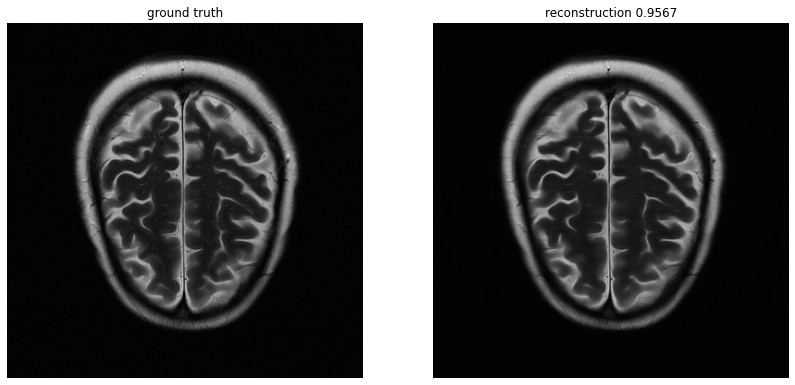

In [ ]:
file = random.choice(list(outputs))
output = outputs[file]
target = targets[file]
slice = output.shape[0] // 2

# compute skimage-format ssim score
score = skimage_ssim(np.array([target[slice]]), np.array([output[slice]]))

# visualize
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(121)
ax.imshow(target[slice], "gray")
ax.set_title("ground truth")
ax.axis("off")

ax = fig.add_subplot(122)
ax.imshow(output[slice], "gray")
ax.set_title("reconstruction {0:.4f}".format(score))
ax.axis("off")

plt.show()